### **Libraries Used**

In [7]:
## Install the missingpy package for imputation
#%pip install missingpy

## Install the missingno package for visualizing missing data

#%pip install missingno

In [8]:
## Load modules

# Standard modules
import pandas as pd
import numpy as np
import os
import sklearn

# Statistics module
import scipy.stats as ss

# Regular expression module
import re


# sklearn 0.22.1 onwards uses sklearn.neighbors._base instead of sklearn.neighbors.base
# re register with alias in such cases
import sys
if sklearn.__version__ >= '0.22.1':
    import sklearn.neighbors._base
    sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

# Preprocessing modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,\
 OneHotEncoder, LabelEncoder, OrdinalEncoder

# Train-test split module
from sklearn.model_selection import train_test_split

# Model selection modules
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import LeaveOneOut

# Pipeline module
from sklearn.pipeline import Pipeline

# Imputation modules
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from missingpy import MissForest
import missingno as msno

# Classifier modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Regression modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import ExtraTreeRegressor

# Clustering modules
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# Performance metric modules
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots

pd.options.display.max_columns = None

# Module for categorical variables
from pandas.api.types import CategoricalDtype

# Modules for building custom encoders and transformers
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
pd.set_option('display.max_rows', 500)

### **Data Cleaning**

In [10]:
## Load Sepsis Data
#file = DATA_DIR+'ICU.csv'
file = 'SepsisDataSet.csv'
sepsisDf = pd.read_csv(file, sep = ',', header = 0)

print('Sepsis dataset')
print('-----------')
print('Initial number of samples = %d'%(sepsisDf.shape[0]))
print('Initial number of features = %d\n'%(sepsisDf.shape[1]))
sepsisDf.head(5)

Sepsis dataset
-----------
Initial number of samples = 449
Initial number of features = 64



,Age,Sex,Speciality,DOAHOSP,IDOAICU,DOICU,DODHOSP,VAR00001,Clinical_Diagnosis,expired_within_48hr,Pnemonia,UTI,Acute_abdominal_infection,meningitis,soft_tissue_infection,bone_joint_infection,wound_infection,CABSI,Endocarditis,implantable_device_infection,Gynaecological_infection,Deep_organ_abscess,others,Hyperthermia,Hypothermia,altered_mental_status,Tachycardia,Tachypnea,Leukocytosis,Leukopenia,Hyperglycemia,SBP,URINE_OUTPUT,SaO2,FiO2,pH,PaO2,TLC,DLC,Bands,Hb,ESR,Platelet_count,AST,ALK_phosphatase,Total_Blirubin,Urea,Creatinine,RBS,Gly_Hb,CRP,GCS,Blood_culture_positive,immunocompromised,HIV,HBsAg,Diabetes,steroid,previous_hospitaliation,Hypertention,Asthma,COPD,Renal_disease,PROGNOSIS
0,76.0,F,MED,28.11.16,28.11.16,30.11.16,03.12.16,ED,,NaN,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,No,Yes,No,Yes,150.0,100.0,91.0,0.6,7.41,60.0,30000.0,"N-77%, left shift+,L-8%,M-4%, Band-24%",24.0,9.4,26.0,392000.0,26.0,175.0,0.5,16.1,1.1,162.0,5.5,NaN,6.0,Yes,no,No,No,Yes,No,No,yes,No,No,No,Recovered
1,35.0,M,SUR,25.11.16,01.12.16,08.12.16,14.12.16,other ICU,Perforation peritonitis,no,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes,No,No,Yes,Yes,Yes,No,Yes,130.0,30.0,99.0,0.4,7.12,232.0,14600.0,"N-70%, left shift+, L-4%, M-2%, Band-60%",60.0,17.2,4.0,263000.0,55.0,84.0,0.5,73.0,1.2,195.0,5.9,NaN,8.0,No,no,No,No,No,No,No,No,No,No,No,died
2,58.0,F,MED,01.12.16,01.12.16,06.12.16,06.12.16,ED,"Mengigo-encephalitis, AkI,T2DM",NaN,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,Yes,Yes,No,Yes,140.0,200.0,97.0,0.4,7.38,101.0,39900.0,"N-76%, left shift, L-6%, M-5%, Band-12%",12.0,11.1,69.0,146000.0,50.0,134.0,1.0,160.0,3.4,158.0,5.0,431.0,8.0,Yes,no,No,No,Yes,No,No,No,No,No,yes,Recovered
3,42.0,M,MED,03.12.16,03.12.16,25.01.17,25.01.17,ED,"Pyomyositis,sepsis with septic shock, MODS, AKI",NaN,No,No,No,No,Yes,No,No,No,No,No,No,No,No,Yes,No,No,Yes,Yes,Yes,No,No,80.0,100.0,98.0,0.4,7.32,165.0,16700.0,"N-57%, left shift+, L-10%, M-8%, Band-19%",19.0,18.4,4.0,135000.0,147.0,28.0,1.5,33.0,1.8,131.0,5.9,130.8,8.0,Yes,no,No,No,No,No,No,No,No,No,No,Recovered
4,52.0,M,MED,03.12.16,03.12.16,12.12.16,12.12.16,ED,Rt sided pneumonia with sepsis,no,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,No,Yes,110.0,50.0,85.0,0.6,7.34,53.0,1800.0,"N-25%, left shift, L-14%, M-3%, Bands-46%",46.0,9.8,4.0,50000.0,658.0,199.0,2.5,41.0,1.1,411.0,6.1,86.0,8.0,No,no,No,No,Yes,No,No,yes,No,No,No,died


In [11]:
sepsisDf.dropna(how = 'all', inplace = True)

print('Sepsis dataset after dropping records having all NaN values')
print('-----------')
print('Number of samples = %d'%(sepsisDf.shape[0]))
print('Number of features = %d\n'%(sepsisDf.shape[1]))
sepsisDf.head(5)

Sepsis dataset after dropping records having all NaN values
-----------
Number of samples = 400
Number of features = 64



,Age,Sex,Speciality,DOAHOSP,IDOAICU,DOICU,DODHOSP,VAR00001,Clinical_Diagnosis,expired_within_48hr,Pnemonia,UTI,Acute_abdominal_infection,meningitis,soft_tissue_infection,bone_joint_infection,wound_infection,CABSI,Endocarditis,implantable_device_infection,Gynaecological_infection,Deep_organ_abscess,others,Hyperthermia,Hypothermia,altered_mental_status,Tachycardia,Tachypnea,Leukocytosis,Leukopenia,Hyperglycemia,SBP,URINE_OUTPUT,SaO2,FiO2,pH,PaO2,TLC,DLC,Bands,Hb,ESR,Platelet_count,AST,ALK_phosphatase,Total_Blirubin,Urea,Creatinine,RBS,Gly_Hb,CRP,GCS,Blood_culture_positive,immunocompromised,HIV,HBsAg,Diabetes,steroid,previous_hospitaliation,Hypertention,Asthma,COPD,Renal_disease,PROGNOSIS
0,76.0,F,MED,28.11.16,28.11.16,30.11.16,03.12.16,ED,,NaN,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,No,Yes,No,Yes,150.0,100.0,91.0,0.6,7.41,60.0,30000.0,"N-77%, left shift+,L-8%,M-4%, Band-24%",24.0,9.4,26.0,392000.0,26.0,175.0,0.5,16.1,1.1,162.0,5.5,NaN,6.0,Yes,no,No,No,Yes,No,No,yes,No,No,No,Recovered
1,35.0,M,SUR,25.11.16,01.12.16,08.12.16,14.12.16,other ICU,Perforation peritonitis,no,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes,No,No,Yes,Yes,Yes,No,Yes,130.0,30.0,99.0,0.4,7.12,232.0,14600.0,"N-70%, left shift+, L-4%, M-2%, Band-60%",60.0,17.2,4.0,263000.0,55.0,84.0,0.5,73.0,1.2,195.0,5.9,NaN,8.0,No,no,No,No,No,No,No,No,No,No,No,died
2,58.0,F,MED,01.12.16,01.12.16,06.12.16,06.12.16,ED,"Mengigo-encephalitis, AkI,T2DM",NaN,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,Yes,Yes,No,Yes,140.0,200.0,97.0,0.4,7.38,101.0,39900.0,"N-76%, left shift, L-6%, M-5%, Band-12%",12.0,11.1,69.0,146000.0,50.0,134.0,1.0,160.0,3.4,158.0,5.0,431.0,8.0,Yes,no,No,No,Yes,No,No,No,No,No,yes,Recovered
3,42.0,M,MED,03.12.16,03.12.16,25.01.17,25.01.17,ED,"Pyomyositis,sepsis with septic shock, MODS, AKI",NaN,No,No,No,No,Yes,No,No,No,No,No,No,No,No,Yes,No,No,Yes,Yes,Yes,No,No,80.0,100.0,98.0,0.4,7.32,165.0,16700.0,"N-57%, left shift+, L-10%, M-8%, Band-19%",19.0,18.4,4.0,135000.0,147.0,28.0,1.5,33.0,1.8,131.0,5.9,130.8,8.0,Yes,no,No,No,No,No,No,No,No,No,No,Recovered
4,52.0,M,MED,03.12.16,03.12.16,12.12.16,12.12.16,ED,Rt sided pneumonia with sepsis,no,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,No,Yes,110.0,50.0,85.0,0.6,7.34,53.0,1800.0,"N-25%, left shift, L-14%, M-3%, Bands-46%",46.0,9.8,4.0,50000.0,658.0,199.0,2.5,41.0,1.1,411.0,6.1,86.0,8.0,No,no,No,No,Yes,No,No,yes,No,No,No,died


<AxesSubplot:>

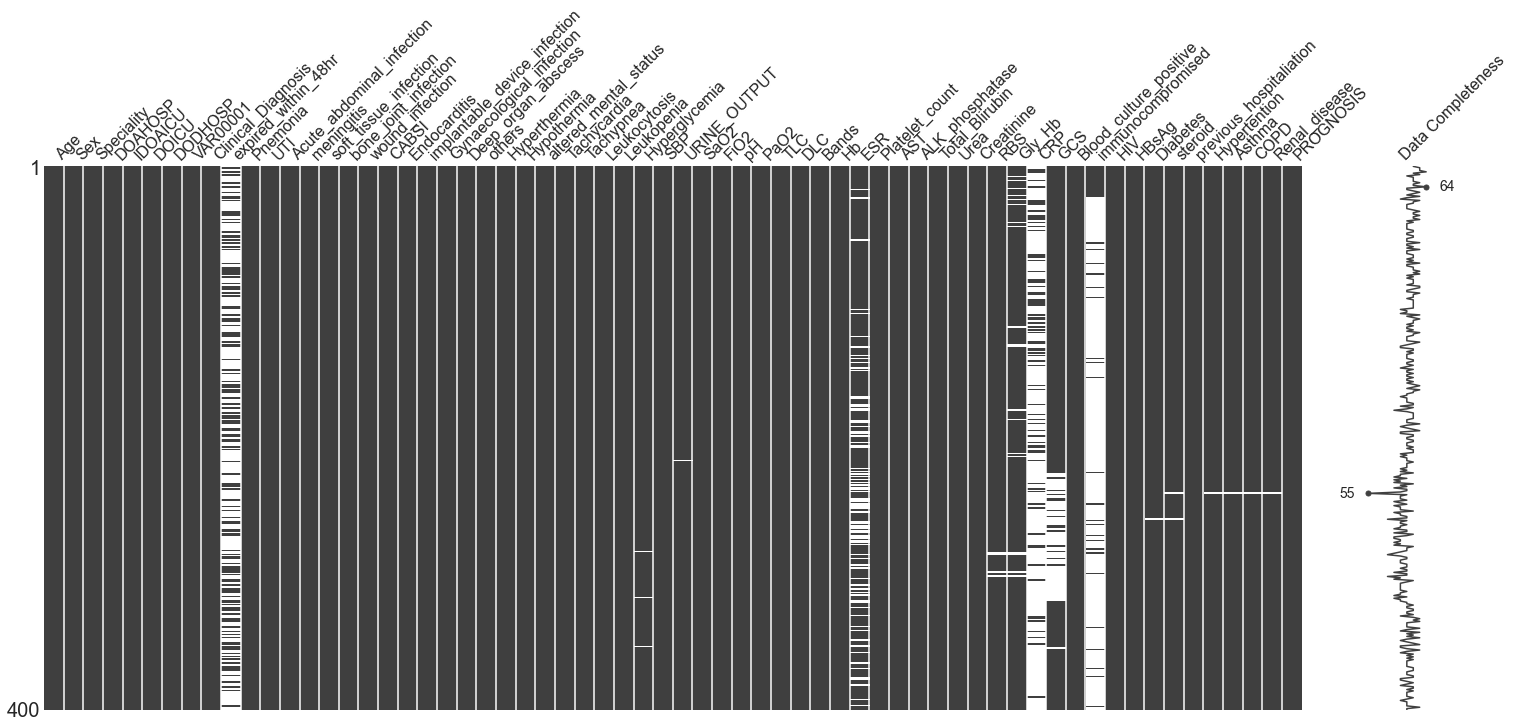

In [12]:
# Plot missingness matrix of the ICU dataset
msno.matrix(sepsisDf,labels=True)

<AxesSubplot:>

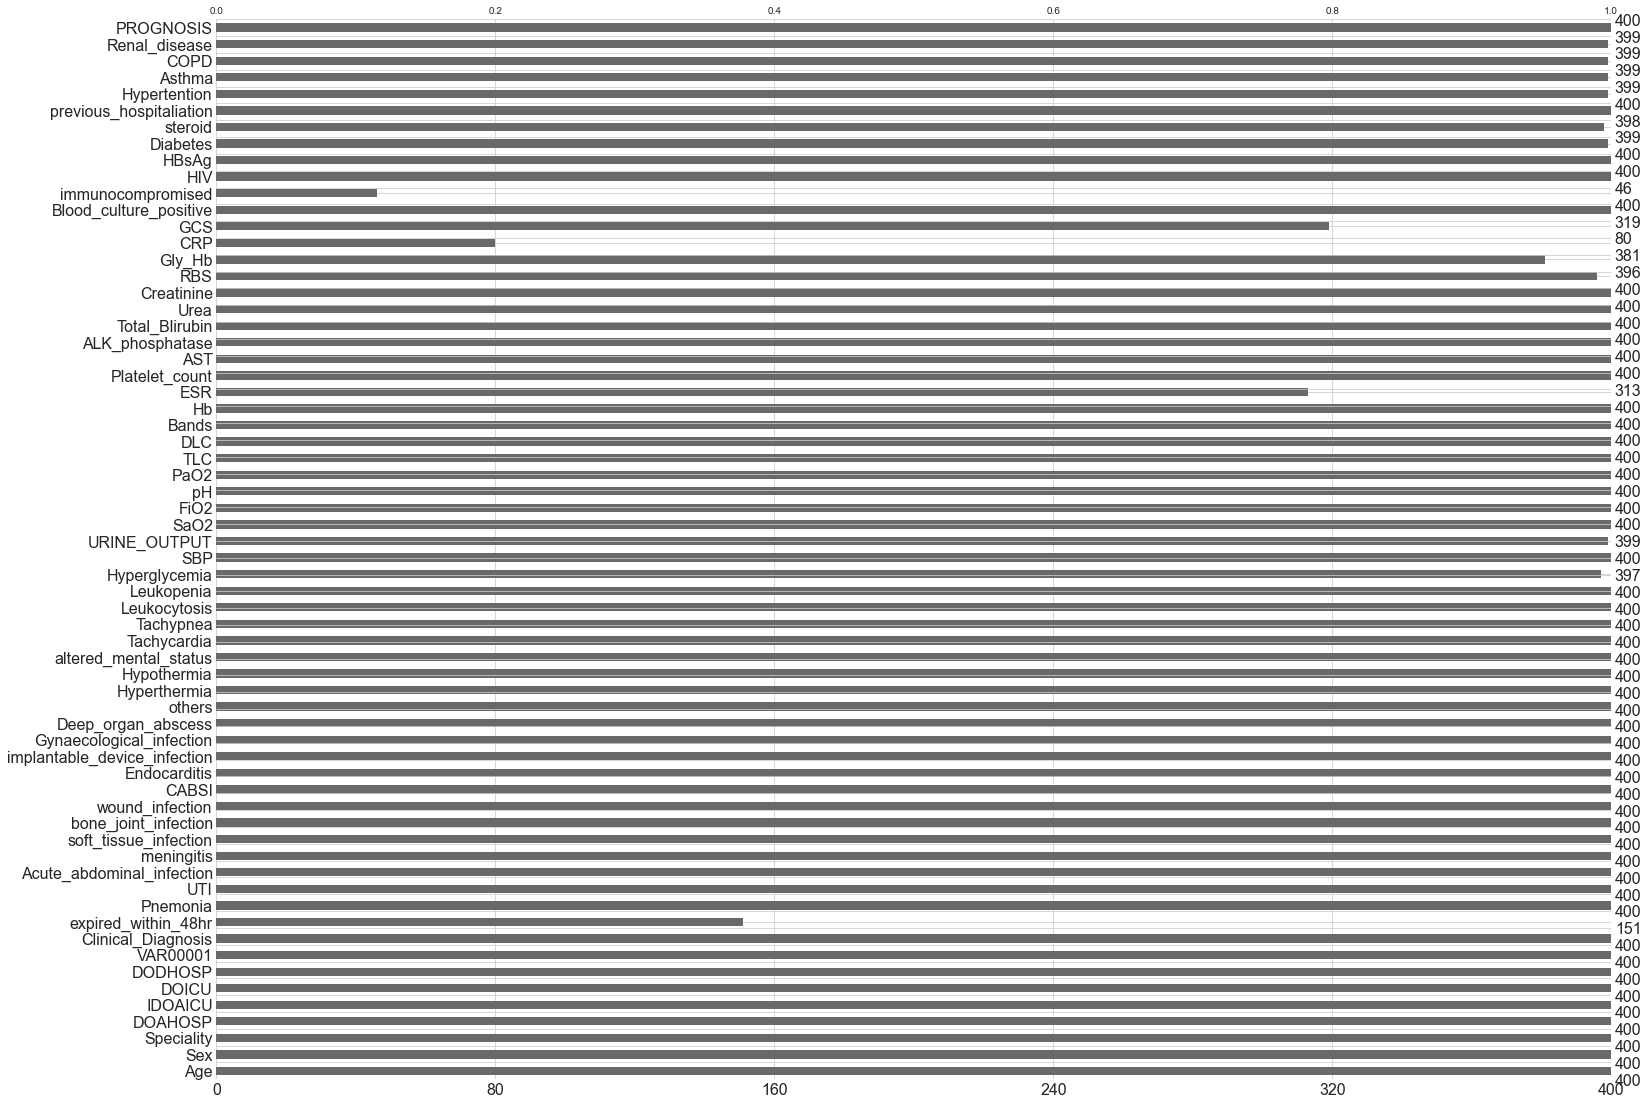

In [13]:
#Missing data -> barplot
msno.bar(sepsisDf)

Text(0, 0.5, '% Missing Values')

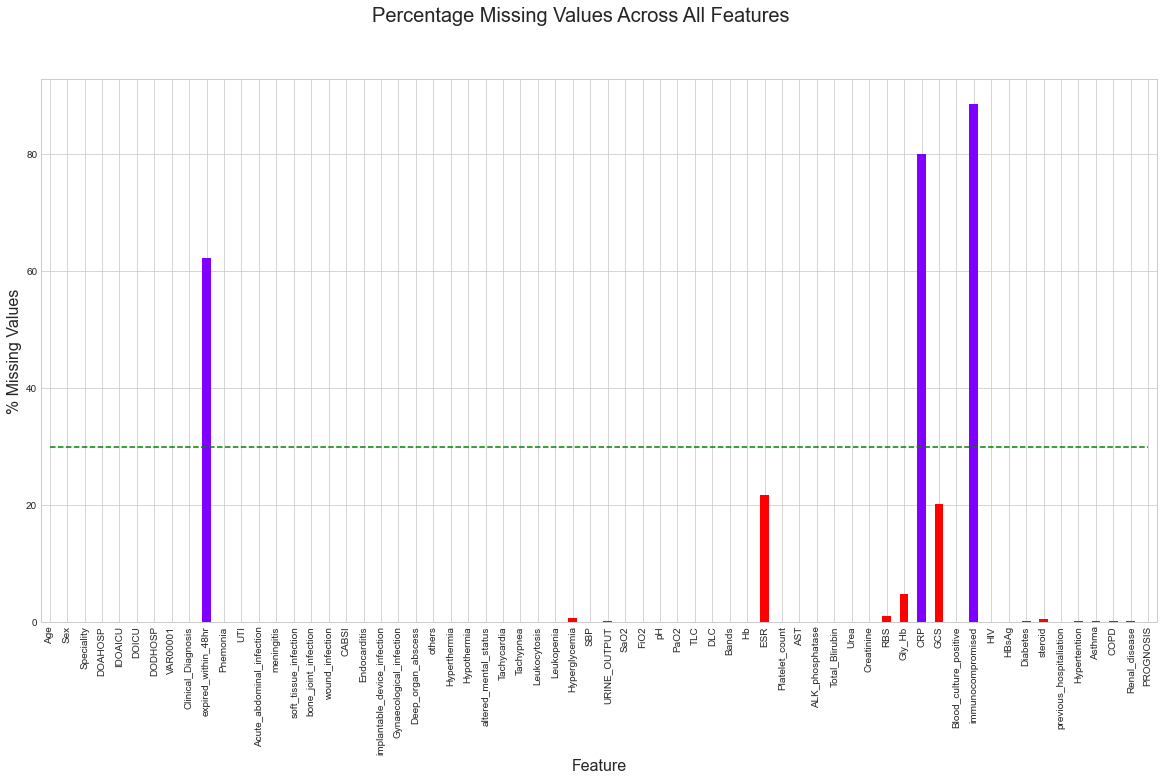

In [14]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 30 # we will remove features missing in more than 30% of the samples
fig = plt.figure(figsize=(20,10))
percent_missing = (sepsisDf.isna().sum() / sepsisDf.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(sepsisDf.shape[1]), np.repeat(cutoff, sepsisDf.shape[1]), 'g--') 
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 20)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('% Missing Values', fontsize = 16)

In [15]:
#Percentage of missing values across all features
percent_missing = (sepsisDf.isna().sum() / sepsisDf.shape[0])*100
missingDf = pd.DataFrame(percent_missing)
missingDf.index.rename('Features',inplace=True)
missingDf.columns = ['Percent_Missing']

missingDf['No. of Missing Values'] = list(sepsisDf.isna().sum())

print("Missing Value Table")
missingDf[missingDf['Percent_Missing'] > 0].sort_values(by=['Percent_Missing'],ascending= False)

Missing Value Table


,Percent_Missing,No. of Missing Values
Features,,
immunocompromised,88.50,354
CRP,80.00,320
expired_within_48hr,62.25,249
ESR,21.75,87
GCS,20.25,81
Gly_Hb,4.75,19
RBS,1.00,4
Hyperglycemia,0.75,3
steroid,0.50,2


In [16]:
#Retain features with Percent_Missing <= 30%
filteredFeatures = sepsisDf.columns[percent_missing <= 30]

# Get Dataframe coressponding to filtered features
filteredSepsisDf = sepsisDf[filteredFeatures].copy()

#Drop Clinical_Diagnosis and DLC column

filteredSepsisDf.drop(columns = ['Clinical_Diagnosis','DLC'], inplace= True)

print('Filtered Dataset with features whose missing percentage value is <= 30 %')
print('-----------')
print('Number of samples = %d'%(filteredSepsisDf.shape[0]))
print('Number of features = %d\n'%(filteredSepsisDf.shape[1]))
filteredSepsisDf.head(5)

Filtered Dataset with features whose missing percentage value is <= 30 %
-----------
Number of samples = 400
Number of features = 59



,Age,Sex,Speciality,DOAHOSP,IDOAICU,DOICU,DODHOSP,VAR00001,Pnemonia,UTI,Acute_abdominal_infection,meningitis,soft_tissue_infection,bone_joint_infection,wound_infection,CABSI,Endocarditis,implantable_device_infection,Gynaecological_infection,Deep_organ_abscess,others,Hyperthermia,Hypothermia,altered_mental_status,Tachycardia,Tachypnea,Leukocytosis,Leukopenia,Hyperglycemia,SBP,URINE_OUTPUT,SaO2,FiO2,pH,PaO2,TLC,Bands,Hb,ESR,Platelet_count,AST,ALK_phosphatase,Total_Blirubin,Urea,Creatinine,RBS,Gly_Hb,GCS,Blood_culture_positive,HIV,HBsAg,Diabetes,steroid,previous_hospitaliation,Hypertention,Asthma,COPD,Renal_disease,PROGNOSIS
0,76.0,F,MED,28.11.16,28.11.16,30.11.16,03.12.16,ED,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,No,Yes,No,Yes,150.0,100.0,91.0,0.6,7.41,60.0,30000.0,24.0,9.4,26.0,392000.0,26.0,175.0,0.5,16.1,1.1,162.0,5.5,6.0,Yes,No,No,Yes,No,No,yes,No,No,No,Recovered
1,35.0,M,SUR,25.11.16,01.12.16,08.12.16,14.12.16,other ICU,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes,No,No,Yes,Yes,Yes,No,Yes,130.0,30.0,99.0,0.4,7.12,232.0,14600.0,60.0,17.2,4.0,263000.0,55.0,84.0,0.5,73.0,1.2,195.0,5.9,8.0,No,No,No,No,No,No,No,No,No,No,died
2,58.0,F,MED,01.12.16,01.12.16,06.12.16,06.12.16,ED,No,No,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,Yes,Yes,No,Yes,140.0,200.0,97.0,0.4,7.38,101.0,39900.0,12.0,11.1,69.0,146000.0,50.0,134.0,1.0,160.0,3.4,158.0,5.0,8.0,Yes,No,No,Yes,No,No,No,No,No,yes,Recovered
3,42.0,M,MED,03.12.16,03.12.16,25.01.17,25.01.17,ED,No,No,No,No,Yes,No,No,No,No,No,No,No,No,Yes,No,No,Yes,Yes,Yes,No,No,80.0,100.0,98.0,0.4,7.32,165.0,16700.0,19.0,18.4,4.0,135000.0,147.0,28.0,1.5,33.0,1.8,131.0,5.9,8.0,Yes,No,No,No,No,No,No,No,No,No,Recovered
4,52.0,M,MED,03.12.16,03.12.16,12.12.16,12.12.16,ED,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,No,Yes,110.0,50.0,85.0,0.6,7.34,53.0,1800.0,46.0,9.8,4.0,50000.0,658.0,199.0,2.5,41.0,1.1,411.0,6.1,8.0,No,No,No,Yes,No,No,yes,No,No,No,died


In [17]:
#Convert dates to pandas date_time object
filteredSepsisDf[filteredSepsisDf.columns[3:7]] = filteredSepsisDf.iloc[:,3:7].apply(pd.to_datetime,errors= 'coerce')

In [18]:
#Create list of ordinal, categorical and continous features
ordinalFeatures = ['GCS']
categoricalFeatures = list(filteredSepsisDf.columns[1:3])+ list(filteredSepsisDf.columns[7:8]) + list(filteredSepsisDf.columns[8:29]) +list(filteredSepsisDf.columns[48:59])
continuousFeatures = filteredSepsisDf.columns[~filteredSepsisDf.columns.isin(ordinalFeatures + categoricalFeatures)].to_list()

#Remove output label from categorical features
categoricalFeatures.remove('PROGNOSIS')


print("Feature Grouping")
print("-----------------")
print("Ordinal Features\n")
print(ordinalFeatures)
print("\nNumber of Ordinal Features : %d"%(len(ordinalFeatures)))
print("-----------------")
print("Categorical Features\n")
print(categoricalFeatures)
print("\nNumber of Categorical Features : %d"%(len(categoricalFeatures)))
print("-----------------")
print("Continuous Features\n")
print(continuousFeatures)
print("\nNumber of Continuous Features : %d"%(len(continuousFeatures)))

Feature Grouping
-----------------
Ordinal Features

['GCS']

Number of Ordinal Features : 1
-----------------
Categorical Features

['Sex', 'Speciality', 'VAR00001', 'Pnemonia', 'UTI', 'Acute_abdominal_infection', 'meningitis', 'soft_tissue_infection', 'bone_joint_infection', 'wound_infection', 'CABSI', 'Endocarditis', 'implantable_device_infection', 'Gynaecological_infection', 'Deep_organ_abscess', 'others', 'Hyperthermia', 'Hypothermia', 'altered_mental_status', 'Tachycardia', 'Tachypnea', 'Leukocytosis', 'Leukopenia', 'Hyperglycemia', 'Blood_culture_positive', 'HIV', 'HBsAg', 'Diabetes', 'steroid', 'previous_hospitaliation', 'Hypertention', 'Asthma', 'COPD', 'Renal_disease']

Number of Categorical Features : 34
-----------------
Continuous Features

['Age', 'DOAHOSP', 'IDOAICU', 'DOICU', 'DODHOSP', 'SBP', 'URINE_OUTPUT', 'SaO2', 'FiO2', 'pH', 'PaO2', 'TLC', 'Bands', 'Hb', 'ESR', 'Platelet_count', 'AST', 'ALK_phosphatase', 'Total_Blirubin', 'Urea', 'Creatinine', 'RBS', 'Gly_Hb']

Nu

In [19]:
# Feature and Output Label Dataframe
featuresDf = filteredSepsisDf.drop(['PROGNOSIS'], axis = 1).copy()
outputDf = sepsisDf[['PROGNOSIS']].copy()

print('Filtered Sepsis dataset')
print('--------------------')
print('Number of samples = %d'%(featuresDf.shape[0]))
print('Number of features = %d'%(featuresDf.shape[1]))
print('Features: ', featuresDf.columns.values)
print('--------------------')
print('Number of output labels = %d'%(outputDf.shape[1]))
print('Output labels: ', outputDf.columns.values)



Filtered Sepsis dataset
--------------------
Number of samples = 400
Number of features = 58
Features:  ['Age' 'Sex' 'Speciality' 'DOAHOSP' 'IDOAICU' 'DOICU' 'DODHOSP' 'VAR00001'
 'Pnemonia' 'UTI' 'Acute_abdominal_infection' 'meningitis'
 'soft_tissue_infection' 'bone_joint_infection' 'wound_infection' 'CABSI'
 'Endocarditis' 'implantable_device_infection' 'Gynaecological_infection'
 'Deep_organ_abscess' 'others' 'Hyperthermia' 'Hypothermia'
 'altered_mental_status' 'Tachycardia' 'Tachypnea' 'Leukocytosis'
 'Leukopenia' 'Hyperglycemia' 'SBP' 'URINE_OUTPUT' 'SaO2' 'FiO2' 'pH'
 'PaO2' 'TLC' 'Bands' 'Hb' 'ESR' 'Platelet_count' 'AST' 'ALK_phosphatase'
 'Total_Blirubin' 'Urea' 'Creatinine' 'RBS' 'Gly_Hb' 'GCS'
 'Blood_culture_positive' 'HIV' 'HBsAg' 'Diabetes' 'steroid'
 'previous_hospitaliation' 'Hypertention' 'Asthma' 'COPD' 'Renal_disease']
--------------------
Number of output labels = 1
Output labels:  ['PROGNOSIS']


In [20]:
## Print unique values in each ordinal and categorical features
print(featuresDf[ordinalFeatures + categoricalFeatures].nunique())
print('\nUnique values in ordinal and categorical features')
print('---------------------------------------------------')
unique_values = {col:list(featuresDf[col].unique()) for col in ordinalFeatures + categoricalFeatures}
for key, value in unique_values.items():
  print(key,value)

GCS                             12
Sex                              2
Speciality                       4
VAR00001                         4
Pnemonia                         2
UTI                              2
Acute_abdominal_infection        2
meningitis                       2
soft_tissue_infection            2
bone_joint_infection             2
wound_infection                  2
CABSI                            2
Endocarditis                     2
implantable_device_infection     2
Gynaecological_infection         2
Deep_organ_abscess               2
others                           2
Hyperthermia                     2
Hypothermia                      2
altered_mental_status            2
Tachycardia                      2
Tachypnea                        2
Leukocytosis                     2
Leukopenia                       2
Hyperglycemia                    2
Blood_culture_positive           2
HIV                              2
HBsAg                            2
Diabetes            

In [21]:
#Convert Yes and No to 1's and 0's
columns = ['Pnemonia',	'UTI',	'Acute_abdominal_infection',	'meningitis',	'soft_tissue_infection',	'bone_joint_infection',	'wound_infection',	'CABSI',	'Endocarditis',	'implantable_device_infection',	'Gynaecological_infection',	'Deep_organ_abscess',	'others',	'Hyperthermia',	'Hypothermia',	'altered_mental_status',	'Tachycardia',	'Tachypnea',	'Leukocytosis',	'Leukopenia',	'Hyperglycemia', 'Blood_culture_positive',	'HIV',	'HBsAg',	'Diabetes',	'steroid',	'previous_hospitaliation',	'Hypertention',	'Asthma',	'COPD',	'Renal_disease']
for column in columns:
  for i in range(len(filteredSepsisDf[column])):
    if 'yes' in str(filteredSepsisDf[column][i]).strip().lower():
      filteredSepsisDf[column][i] = 1
    if 'no' in str(filteredSepsisDf[column][i]).strip().lower():
      filteredSepsisDf[column][i] = 0

  filteredSepsisDf[column] = filteredSepsisDf[column].replace(-1, np.nan)
  filteredSepsisDf[column] = filteredSepsisDf[column].astype('category')  
    

<ipython-input-21-d133d13db9d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredSepsisDf[column][i] = 0
<ipython-input-21-d133d13db9d2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredSepsisDf[column][i] = 1


In [22]:
filteredSepsisDf.head()

,Age,Sex,Speciality,DOAHOSP,IDOAICU,DOICU,DODHOSP,VAR00001,Pnemonia,UTI,Acute_abdominal_infection,meningitis,soft_tissue_infection,bone_joint_infection,wound_infection,CABSI,Endocarditis,implantable_device_infection,Gynaecological_infection,Deep_organ_abscess,others,Hyperthermia,Hypothermia,altered_mental_status,Tachycardia,Tachypnea,Leukocytosis,Leukopenia,Hyperglycemia,SBP,URINE_OUTPUT,SaO2,FiO2,pH,PaO2,TLC,Bands,Hb,ESR,Platelet_count,AST,ALK_phosphatase,Total_Blirubin,Urea,Creatinine,RBS,Gly_Hb,GCS,Blood_culture_positive,HIV,HBsAg,Diabetes,steroid,previous_hospitaliation,Hypertention,Asthma,COPD,Renal_disease,PROGNOSIS
0,76.0,F,MED,2016-11-28,2016-11-28,2016-11-30,2016-03-12,ED,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,150.0,100.0,91.0,0.6,7.41,60.0,30000.0,24.0,9.4,26.0,392000.0,26.0,175.0,0.5,16.1,1.1,162.0,5.5,6.0,1,0,0,1,0,0,1,0,0,0,Recovered
1,35.0,M,SUR,2016-11-25,2016-01-12,2016-08-12,2016-12-14,other ICU,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,130.0,30.0,99.0,0.4,7.12,232.0,14600.0,60.0,17.2,4.0,263000.0,55.0,84.0,0.5,73.0,1.2,195.0,5.9,8.0,0,0,0,0,0,0,0,0,0,0,died
2,58.0,F,MED,2016-01-12,2016-01-12,2016-06-12,2016-06-12,ED,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,140.0,200.0,97.0,0.4,7.38,101.0,39900.0,12.0,11.1,69.0,146000.0,50.0,134.0,1.0,160.0,3.4,158.0,5.0,8.0,1,0,0,1,0,0,0,0,0,1,Recovered
3,42.0,M,MED,2016-03-12,2016-03-12,2017-01-25,2017-01-25,ED,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,80.0,100.0,98.0,0.4,7.32,165.0,16700.0,19.0,18.4,4.0,135000.0,147.0,28.0,1.5,33.0,1.8,131.0,5.9,8.0,1,0,0,0,0,0,0,0,0,0,Recovered
4,52.0,M,MED,2016-03-12,2016-03-12,2016-12-12,2016-12-12,ED,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,110.0,50.0,85.0,0.6,7.34,53.0,1800.0,46.0,9.8,4.0,50000.0,658.0,199.0,2.5,41.0,1.1,411.0,6.1,8.0,0,0,0,1,0,0,1,0,0,0,died


In [23]:
#drop rows where PROGNOSIS = 2 (lost to follow up)
filteredSepsisDf = filteredSepsisDf.drop(filteredSepsisDf[filteredSepsisDf['PROGNOSIS'] == 'lost to followup'].index)

In [24]:
#Encode remaining Categorical Features
CategoricalColumns = list(set(categoricalFeatures) - set(columns)) + ['PROGNOSIS']

for col in CategoricalColumns:
  cat_type = 'category'
  filteredSepsisDf[col] = filteredSepsisDf[col].astype(cat_type).factorize()[0] 
  filteredSepsisDf[col] = filteredSepsisDf[col].astype('category')  
  filteredSepsisDf[col] = filteredSepsisDf[col].replace(-1, np.nan)  

filteredSepsisDf.dtypes

Age                                    float64
Sex                                   category
Speciality                            category
DOAHOSP                         datetime64[ns]
IDOAICU                         datetime64[ns]
DOICU                           datetime64[ns]
DODHOSP                         datetime64[ns]
VAR00001                              category
Pnemonia                              category
UTI                                   category
Acute_abdominal_infection             category
meningitis                            category
soft_tissue_infection                 category
bone_joint_infection                  category
wound_infection                       category
CABSI                                 category
Endocarditis                          category
implantable_device_infection          category
Gynaecological_infection              category
Deep_organ_abscess                    category
others                                category
Hyperthermia 

In [25]:
#Drop GCS -> Feature not required
filteredSepsisDf =  filteredSepsisDf.drop(columns=['GCS'])

In [26]:
filteredSepsisDf.shape
#filteredSepsisDf.to_csv("sepsis_preprocessing_1.csv")

(350, 58)

### **Handling Missing Data**

#### Missing Data in Categorical Features

In [27]:
#Nan in categorical features
row_has_NaN = filteredSepsisDf.select_dtypes('category').isnull().any(axis=1)
filteredSepsisDf = filteredSepsisDf[~row_has_NaN]
filteredSepsisDf.shape

(345, 58)

In [28]:
#reset index
filteredSepsisDf.reset_index(drop=True,inplace=True)

In [29]:
#Create seperate dataframes for seperate datatypes
categorydf = filteredSepsisDf.select_dtypes('category')
continuousdf = filteredSepsisDf.select_dtypes('float64')
datedf = filteredSepsisDf.select_dtypes('datetime64[ns]')


In [30]:
#drop category label from categorydf
categorydf = categorydf.drop(columns=['PROGNOSIS'])

<AxesSubplot:>

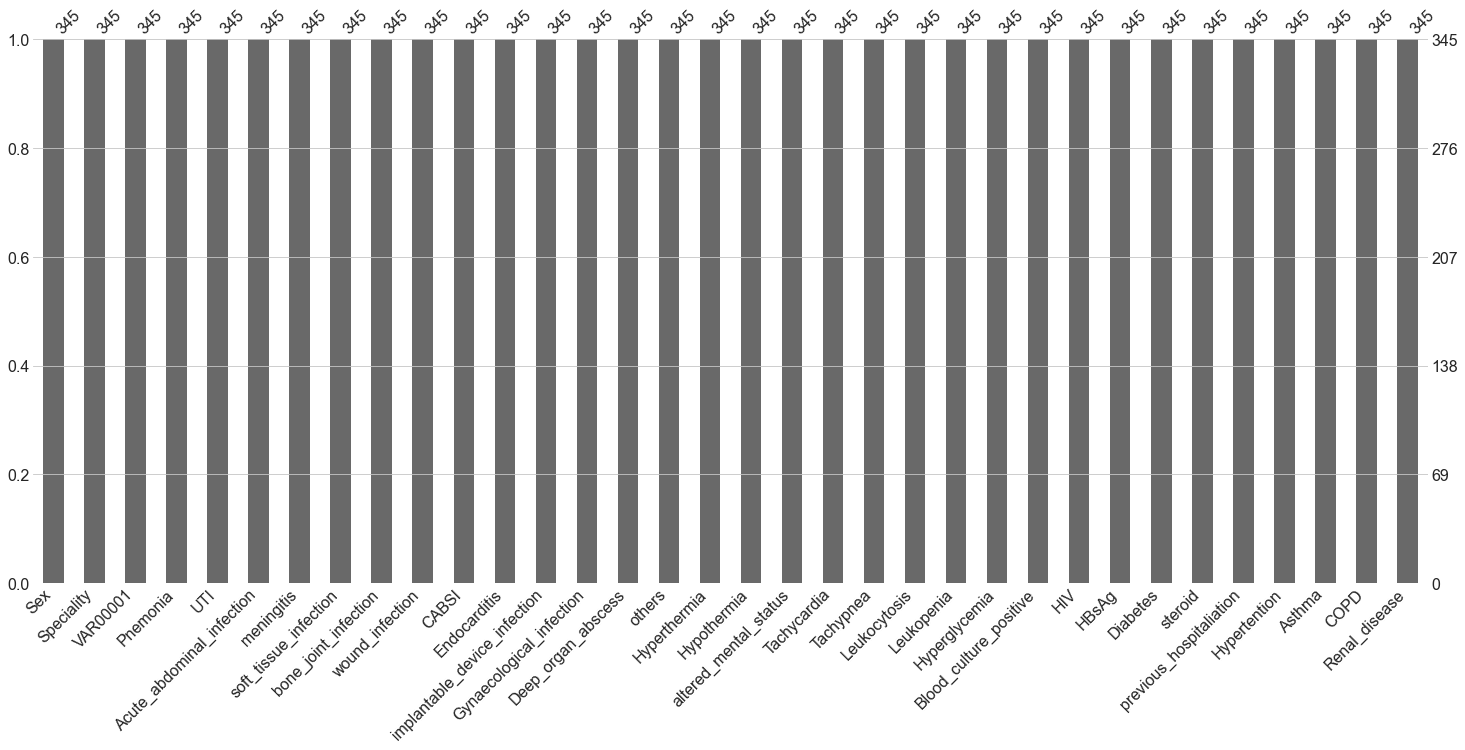

In [31]:
msno.bar(categorydf)

#### Missing Data in Numeric Features


<AxesSubplot:>

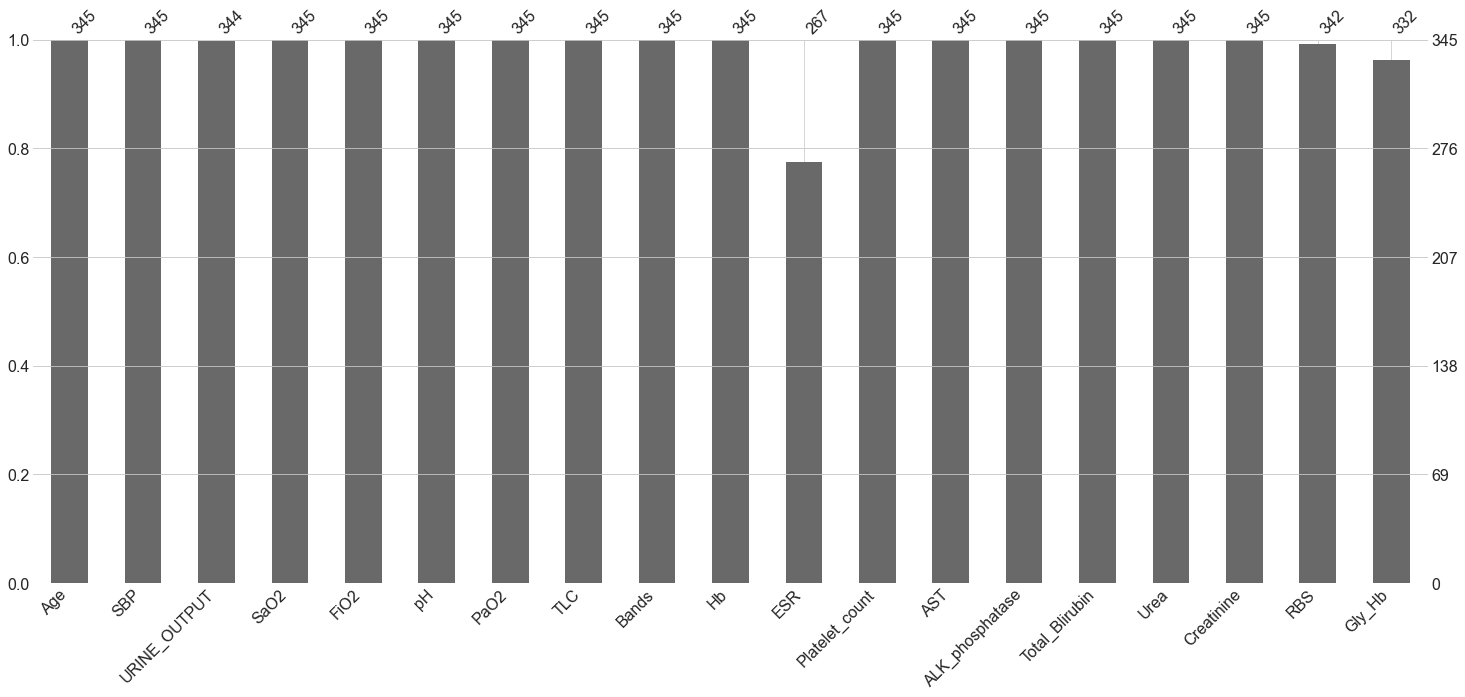

In [32]:
msno.bar(continuousdf)

In [33]:
#Percentage of missing values across all features
percent_missing = (continuousdf.isna().sum() / continuousdf.shape[0])*100
missingDf = pd.DataFrame(percent_missing)
missingDf.index.rename('Features',inplace=True)
missingDf.columns = ['Percent_Missing']

missingDf['No. of Missing Values'] = list(continuousdf.isna().sum())

print("Missing Value Table")
missingDf[missingDf['Percent_Missing'] > 0].sort_values(by=['Percent_Missing'],ascending= False)

Missing Value Table


,Percent_Missing,No. of Missing Values
Features,,
ESR,22.608696,78
Gly_Hb,3.768116,13
RBS,0.869565,3
URINE_OUTPUT,0.289855,1


In [34]:
row_has_NaN = filteredSepsisDf.select_dtypes('float64').isnull().any(axis=1)

In [35]:
continuous_columns = list(continuousdf.columns)

In [36]:
#Random Forest Imputation for Numeric Data
imputer = MissForest(missing_values= "NaN")
X_imputed = imputer.fit_transform(continuousdf)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [37]:
X_imputed

array([[ 76. , 150. , 100. , ...,   1.1, 162. ,   5.5],
       [ 35. , 130. ,  30. , ...,   1.2, 195. ,   5.9],
       [ 58. , 140. , 200. , ...,   3.4, 158. ,   5. ],
       ...,
       [ 48. ,  80. , 120. , ...,   1.3, 100. ,   5.2],
       [ 42. ,  90. , 100. , ...,   1.7, 106. ,   4.8],
       [ 76. ,  90. , 110. , ...,   2.2, 146. ,   7.1]])

In [38]:
continousImputedDf = pd.DataFrame(X_imputed,columns=continuous_columns)
continousImputedDf.shape

(345, 19)

In [39]:
continousImputedDf.isnull().sum()

Age                0
SBP                0
URINE_OUTPUT       0
SaO2               0
FiO2               0
pH                 0
PaO2               0
TLC                0
Bands              0
Hb                 0
ESR                0
Platelet_count     0
AST                0
ALK_phosphatase    0
Total_Blirubin     0
Urea               0
Creatinine         0
RBS                0
Gly_Hb             0
dtype: int64

In [40]:
#Final imputed Dataframe
merged_df1 = pd.merge(datedf,categorydf,left_index=True,right_index=True)
imputedDf = pd.merge(merged_df1,continousImputedDf,left_index=True,right_index=True)

imputedDf.head()

,DOAHOSP,IDOAICU,DOICU,DODHOSP,Sex,Speciality,VAR00001,Pnemonia,UTI,Acute_abdominal_infection,meningitis,soft_tissue_infection,bone_joint_infection,wound_infection,CABSI,Endocarditis,implantable_device_infection,Gynaecological_infection,Deep_organ_abscess,others,Hyperthermia,Hypothermia,altered_mental_status,Tachycardia,Tachypnea,Leukocytosis,Leukopenia,Hyperglycemia,Blood_culture_positive,HIV,HBsAg,Diabetes,steroid,previous_hospitaliation,Hypertention,Asthma,COPD,Renal_disease,Age,SBP,URINE_OUTPUT,SaO2,FiO2,pH,PaO2,TLC,Bands,Hb,ESR,Platelet_count,AST,ALK_phosphatase,Total_Blirubin,Urea,Creatinine,RBS,Gly_Hb
0,2016-11-28,2016-11-28,2016-11-30,2016-03-12,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,76.0,150.0,100.0,91.0,0.6,7.41,60.0,30000.0,24.0,9.4,26.0,392000.0,26.0,175.0,0.5,16.1,1.1,162.0,5.5
1,2016-11-25,2016-01-12,2016-08-12,2016-12-14,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,35.0,130.0,30.0,99.0,0.4,7.12,232.0,14600.0,60.0,17.2,4.0,263000.0,55.0,84.0,0.5,73.0,1.2,195.0,5.9
2,2016-01-12,2016-01-12,2016-06-12,2016-06-12,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,1,58.0,140.0,200.0,97.0,0.4,7.38,101.0,39900.0,12.0,11.1,69.0,146000.0,50.0,134.0,1.0,160.0,3.4,158.0,5.0
3,2016-03-12,2016-03-12,2017-01-25,2017-01-25,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,42.0,80.0,100.0,98.0,0.4,7.32,165.0,16700.0,19.0,18.4,4.0,135000.0,147.0,28.0,1.5,33.0,1.8,131.0,5.9
4,2016-03-12,2016-03-12,2016-12-12,2016-12-12,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,52.0,110.0,50.0,85.0,0.6,7.34,53.0,1800.0,46.0,9.8,4.0,50000.0,658.0,199.0,2.5,41.0,1.1,411.0,6.1


### **Model Selection**

In [41]:
#Training set and test set
xVar = imputedDf.iloc[:,4:]
yVar = filteredSepsisDf.iloc[:,-1]

xTrain,xTest,yTrain,yTest = train_test_split(xVar,yVar,test_size=0.3,random_state=0)

In [42]:
#build classification models

#Random Forest
randomForest = RandomForestClassifier(n_jobs=2,random_state=0)
#Naive Bayes
naiveBayes = GaussianNB()

#Fit Model
randomForest.fit(xTrain,yTrain)
naiveBayes.fit(xTrain,yTrain)

GaussianNB()

In [43]:
#Prediction probabilities 
r_probs = [0 for _ in range(len(yTest))]
rf_probs = randomForest.predict_proba(xTest)
nb_probs = naiveBayes.predict_proba(xTest)

In [44]:
#Probabilities for the positive outcome is kept.
rf_probs = rf_probs[:, 1]
nb_probs = nb_probs[:, 1]

In [45]:
#Calculate AUROC
#ROC is the receiver operating characteristic AUROC is the area under the ROC curve
r_auc = roc_auc_score(yTest, r_probs)
rf_auc = roc_auc_score(yTest, rf_probs)
nb_auc = roc_auc_score(yTest, nb_probs)

In [46]:
#Print AUROC scores
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('Naive Bayes: AUROC = %.3f' % (nb_auc))

Random (chance) Prediction: AUROC = 0.500
Random Forest: AUROC = 0.654
Naive Bayes: AUROC = 0.647


In [47]:
#Calculate ROC curve
r_fpr, r_tpr, _ = roc_curve(yTest, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(yTest, rf_probs)
nb_fpr, nb_tpr, _ = roc_curve(yTest, nb_probs)

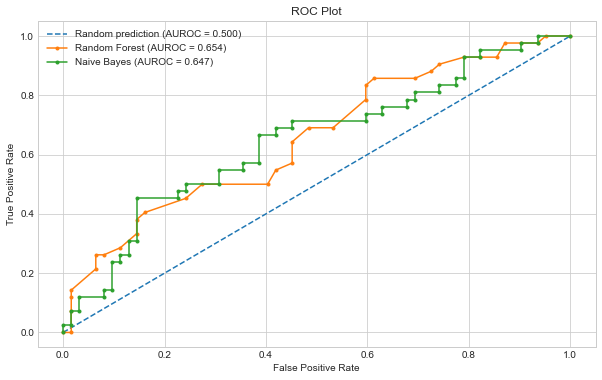

In [48]:
#Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()


### **Classification Model Using Random Forest**

 #### **Split -> 90/10**

In [49]:
#Subset the data -> Exclude date features
xVar = imputedDf.iloc[:,4:]
yVar = filteredSepsisDf.iloc[:,-1]
split = 0.1


#Split the data into training and test sets
xTrain1,xTest1,yTrain1,yTest1 = train_test_split(xVar,yVar,test_size=split)

print(xTrain1.shape,yTrain1.shape)
print(xTest1.shape,yTest1.shape)

(310, 53) (310,)
(35, 53) (35,)


In [50]:
#Build a Random Forest Classifier
classifier = RandomForestClassifier(n_jobs=2,random_state=0)

classifier.fit(xTrain1,yTrain1)


#Predict
prediction1 = classifier.predict(xTest1)

In [51]:
#Check the accuracy of the model -> Confusion Matrix
confusionMatrix1 = pd.crosstab(yTest1, prediction1, rownames=['Actual Result'], colnames=['Predicted Result'])
confusionMatrix1

Predicted Result,0,1
Actual Result,,
0,15,2
1,15,3


In [52]:
#Performance of the model 
def performance_metrics(confusionMatrix,test_size):
    tp = confusionMatrix.iloc[0,0]
    tn = confusionMatrix.iloc[1,1]
    fp = confusionMatrix.iloc[0,1]
    fn = confusionMatrix.iloc[1,0]

    

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)

    data = np.array([test_size,tp,tn,fp,fn,accuracy,precision,recall,f1])
    series = pd.Series(data,index=['Test-Size','True Positive','True Negative','False Positive','False Negative','Accuracy','Precision','Recall','F1-Score'])
    return series
    

performance_metric_test1 = performance_metrics(confusionMatrix1,split)

performance_metric_test1


Test-Size          0.100000
True Positive     15.000000
True Negative      3.000000
False Positive     2.000000
False Negative    15.000000
Accuracy           0.514286
Precision          0.882353
Recall             0.500000
F1-Score           0.638298
dtype: float64

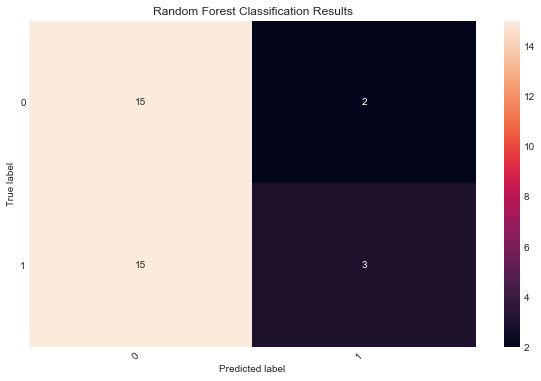

In [53]:
#Confusion Matrix Using Seaborn heatmap
def confusionMatrix_plot(confusionMatrix):
    plt.figure(figsize=(10,6))

    heatmap = sns.heatmap(confusionMatrix, annot=True)

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

    plt.title('Random Forest Classification Results')

    plt.show() 

confusionMatrix_plot(confusionMatrix1)

#### **Split -> 80/20**

In [54]:
#Subset the data -> Exclude date features
xVar = imputedDf.iloc[:,4:]
yVar = filteredSepsisDf.iloc[:,-1]
split = 0.2


#Split the data into training and test sets
xTrain2,xTest2,yTrain2,yTest2 = train_test_split(xVar,yVar,test_size=split)

#Build a Random Forest Classifier
classifier = RandomForestClassifier(n_jobs=2,random_state=0)

classifier.fit(xTrain2,yTrain2)

#Predict
prediction2 = classifier.predict(xTest2)

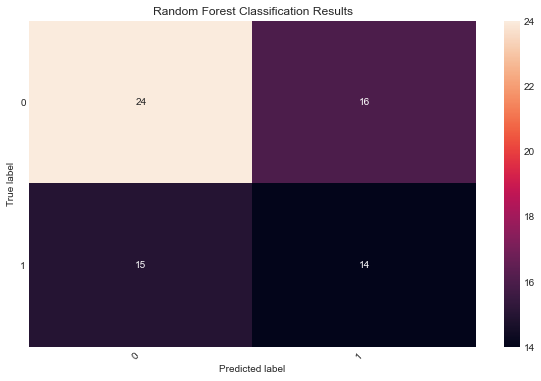

In [55]:
#Check the accuracy of the model -> Confusion Matrix
confusionMatrix2 = pd.crosstab(yTest2, prediction2, rownames=['Actual Result'], colnames=['Predicted Result'])
confusionMatrix_plot(confusionMatrix2)

In [56]:
performance_metric_test2 = performance_metrics(confusionMatrix2,split)
performance_metric_test2

Test-Size          0.200000
True Positive     24.000000
True Negative     14.000000
False Positive    16.000000
False Negative    15.000000
Accuracy           0.550725
Precision          0.600000
Recall             0.615385
F1-Score           0.607595
dtype: float64

#### **Split -> 75/25**

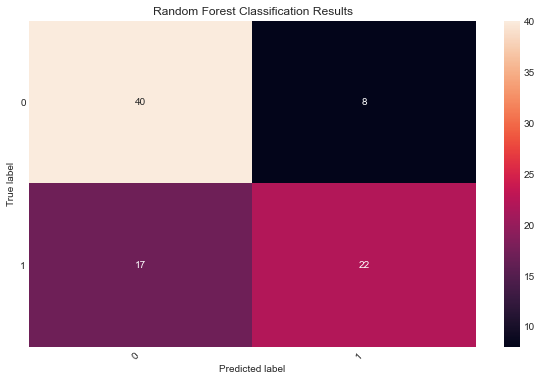

In [57]:
#Subset the data -> Exclude date features
xVar = imputedDf.iloc[:,4:]
yVar = filteredSepsisDf.iloc[:,-1]
split = 0.25


#Split the data into training and test sets
xTrain3,xTest3,yTrain3,yTest3 = train_test_split(xVar,yVar,test_size=split)

#Build a Random Forest Classifier
classifier = RandomForestClassifier(n_jobs=2,random_state=0)

classifier.fit(xTrain3,yTrain3)

#Predict
prediction3 = classifier.predict(xTest3)

#Check the accuracy of the model -> Confusion Matrix
confusionMatrix3 = pd.crosstab(yTest3, prediction3, rownames=['Actual Result'], colnames=['Predicted Result'])
confusionMatrix_plot(confusionMatrix3)


In [58]:
performance_metric_test3 = performance_metrics(confusionMatrix3,split)
performance_metric_test3

Test-Size          0.250000
True Positive     40.000000
True Negative     22.000000
False Positive     8.000000
False Negative    17.000000
Accuracy           0.712644
Precision          0.833333
Recall             0.701754
F1-Score           0.761905
dtype: float64

#### **Split -> 70/30**

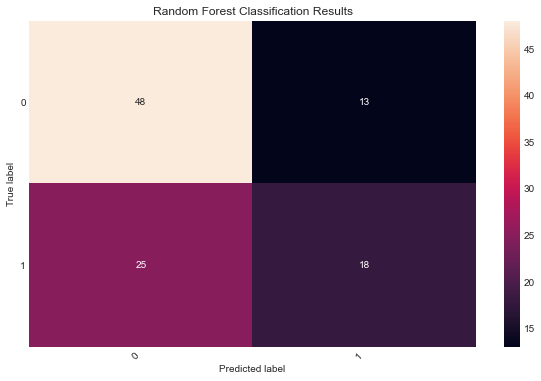

In [59]:
#Subset the data -> Exclude date features
xVar = imputedDf.iloc[:,4:]
yVar = filteredSepsisDf.iloc[:,-1]
split = 0.30


#Split the data into training and test sets
xTrain4,xTest4,yTrain4,yTest4 = train_test_split(xVar,yVar,test_size=split)

#Build a Random Forest Classifier
classifier = RandomForestClassifier(n_jobs=2,random_state=0)

classifier.fit(xTrain4,yTrain4)

#Predict
prediction4 = classifier.predict(xTest4)

#Check the accuracy of the model -> Confusion Matrix
confusionMatrix4 = pd.crosstab(yTest4, prediction4, rownames=['Actual Result'], colnames=['Predicted Result'])
confusionMatrix_plot(confusionMatrix4)



In [60]:
performance_metric_test4 = performance_metrics(confusionMatrix4,split)
performance_metric_test4

Test-Size          0.300000
True Positive     48.000000
True Negative     18.000000
False Positive    13.000000
False Negative    25.000000
Accuracy           0.634615
Precision          0.786885
Recall             0.657534
F1-Score           0.716418
dtype: float64

#### **Split -> 60/40**

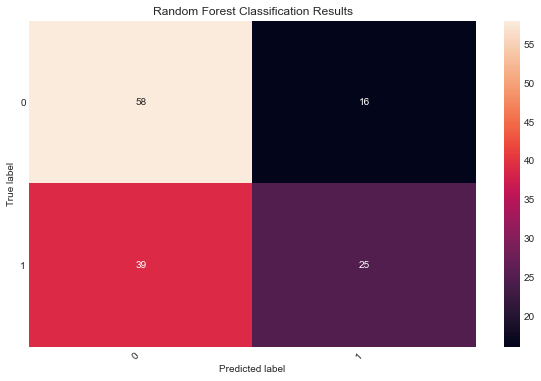

In [61]:
#Subset the data -> Exclude date features
xVar = imputedDf.iloc[:,4:]
yVar = filteredSepsisDf.iloc[:,-1]
split = 0.4


#Split the data into training and test sets
xTrain5,xTest5,yTrain5,yTest5 = train_test_split(xVar,yVar,test_size=split)

#Build a Random Forest Classifier
classifier = RandomForestClassifier(n_jobs=2,random_state=0)

classifier.fit(xTrain5,yTrain5)

#Predict
prediction5 = classifier.predict(xTest5)

#Check the accuracy of the model -> Confusion Matrix
confusionMatrix5 = pd.crosstab(yTest5, prediction5, rownames=['Actual Result'], colnames=['Predicted Result'])
confusionMatrix_plot(confusionMatrix5)

In [62]:
performance_metric_test5 = performance_metrics(confusionMatrix5,split)
performance_metric_test5

Test-Size          0.400000
True Positive     58.000000
True Negative     25.000000
False Positive    16.000000
False Negative    39.000000
Accuracy           0.601449
Precision          0.783784
Recall             0.597938
F1-Score           0.678363
dtype: float64

#### **Split -> 50/50**

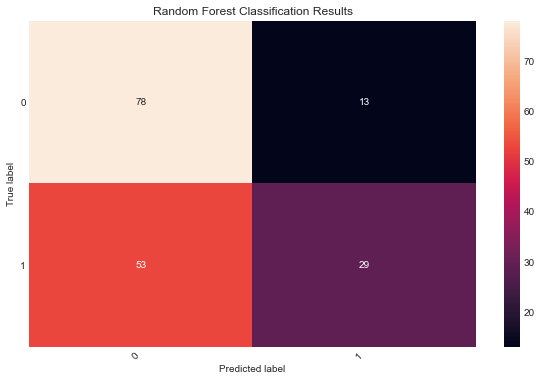

In [63]:
#Subset the data -> Exclude date features
xVar = imputedDf.iloc[:,4:]
yVar = filteredSepsisDf.iloc[:,-1]
split = 0.5


#Split the data into training and test sets
xTrain6,xTest6,yTrain6,yTest6 = train_test_split(xVar,yVar,test_size=split)

#Build a Random Forest Classifier
classifier = RandomForestClassifier(n_jobs=2,random_state=0)

classifier.fit(xTrain6,yTrain6)

#Predict
prediction6 = classifier.predict(xTest6)

#Check the accuracy of the model -> Confusion Matrix
confusionMatrix6 = pd.crosstab(yTest6, prediction6, rownames=['Actual Result'], colnames=['Predicted Result'])
confusionMatrix_plot(confusionMatrix6)

In [64]:
performance_metric_test6 = performance_metrics(confusionMatrix6,split)
performance_metric_test6

Test-Size          0.500000
True Positive     78.000000
True Negative     29.000000
False Positive    13.000000
False Negative    53.000000
Accuracy           0.618497
Precision          0.857143
Recall             0.595420
F1-Score           0.702703
dtype: float64

#### **Performance Evaluation**

In [65]:
#Performance dataframe

performanceDf = pd.DataFrame(columns=['Test-Size','True Positive','True Negative','False Positive','False Negative','Accuracy','Precision','Recall','F1-Score'])

#append
performanceDf = performanceDf.append(performance_metric_test1,ignore_index=True)
performanceDf = performanceDf.append(performance_metric_test2,ignore_index=True)
performanceDf = performanceDf.append(performance_metric_test3,ignore_index=True)
performanceDf = performanceDf.append(performance_metric_test4,ignore_index=True)
performanceDf = performanceDf.append(performance_metric_test5,ignore_index=True)
performanceDf = performanceDf.append(performance_metric_test6,ignore_index=True)



    

In [66]:
performanceDf

,Test-Size,True Positive,True Negative,False Positive,False Negative,Accuracy,Precision,Recall,F1-Score
0,0.10,15.0,3.0,2.0,15.0,0.514286,0.882353,0.500000,0.638298
1,0.20,24.0,14.0,16.0,15.0,0.550725,0.600000,0.615385,0.607595
2,0.25,40.0,22.0,8.0,17.0,0.712644,0.833333,0.701754,0.761905
3,0.30,48.0,18.0,13.0,25.0,0.634615,0.786885,0.657534,0.716418
4,0.40,58.0,25.0,16.0,39.0,0.601449,0.783784,0.597938,0.678363
5,0.50,78.0,29.0,13.0,53.0,0.618497,0.857143,0.595420,0.702703


### **K-Fold Cross Validation**

In [67]:

#Features and output label 
xVar = imputedDf.iloc[:,4:]
yVar = filteredSepsisDf.iloc[:,-1]

#RandomForest Classifier model
classifier = RandomForestClassifier()

# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# evaluate model
scores = cross_val_score(classifier, xVar, yVar, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.632 (0.067)


In [76]:
def get_dataset(n_samples=100):
	x = imputedDf.iloc[:,4:]
	y = filteredSepsisDf.iloc[:,-1]
	return x, y

In [77]:
# retrieve the model to be evaluate
def get_model():
	model = RandomForestClassifier()
	return model

In [78]:
# evaluate the model using a given test condition
def evaluate_model(cv):
	# get the dataset
	X, y = get_dataset()
	# get the model
	model = get_model()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return np.mean(scores), scores.min(), scores.max()

In [79]:
# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)

Ideal: 0.635


In [80]:

# define folds to test
folds = range(2,31)

In [81]:

# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
	# define the test condition
	cv = KFold(n_splits=k, shuffle=True, random_state=1)
	# evaluate k value
	k_mean, k_min, k_max = evaluate_model(cv)
	# report performance
	print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
	# store mean accuracy
	means.append(k_mean)
	# store min and max relative to the mean
	mins.append(k_mean - k_min)
	maxs.append(k_max - k_mean)

> folds=2, accuracy=0.641 (0.628,0.653)
> folds=3, accuracy=0.655 (0.626,0.678)
> folds=4, accuracy=0.641 (0.616,0.674)
> folds=5, accuracy=0.670 (0.594,0.710)
> folds=6, accuracy=0.614 (0.586,0.672)
> folds=7, accuracy=0.635 (0.531,0.755)
> folds=8, accuracy=0.620 (0.568,0.674)
> folds=9, accuracy=0.652 (0.605,0.692)
> folds=10, accuracy=0.638 (0.486,0.800)
> folds=11, accuracy=0.620 (0.484,0.719)
> folds=12, accuracy=0.638 (0.483,0.759)
> folds=13, accuracy=0.650 (0.519,0.769)
> folds=14, accuracy=0.612 (0.480,0.708)
> folds=15, accuracy=0.620 (0.478,0.783)
> folds=16, accuracy=0.618 (0.455,0.727)
> folds=17, accuracy=0.632 (0.500,0.800)
> folds=18, accuracy=0.624 (0.500,0.789)
> folds=19, accuracy=0.641 (0.444,0.833)
> folds=20, accuracy=0.631 (0.412,0.765)
> folds=21, accuracy=0.625 (0.500,0.882)
> folds=22, accuracy=0.641 (0.438,0.812)
> folds=23, accuracy=0.655 (0.467,0.867)
> folds=24, accuracy=0.620 (0.429,0.733)
> folds=25, accuracy=0.623 (0.429,0.786)
> folds=26, accuracy=0.6

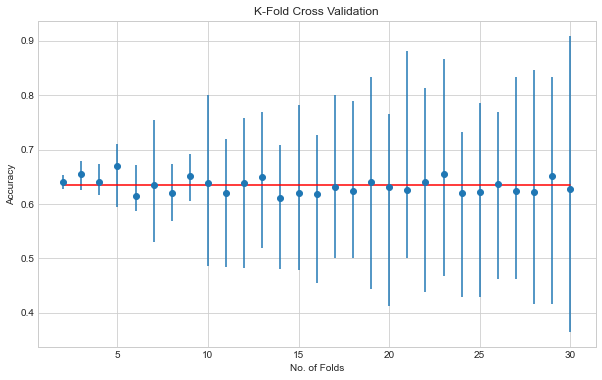

In [82]:
#plot
plt.figure(figsize=(10,6))
plt.title('K-Fold Cross Validation')
plt.xlabel('No. of Folds')
plt.ylabel('Accuracy')
# line plot of k mean values with min/max error bars
plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.show()